**EMOTION DETECTION**


In [1]:
#IMPORT LIBRARY
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.16.1


**exporting dataset**

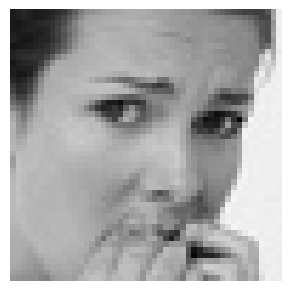

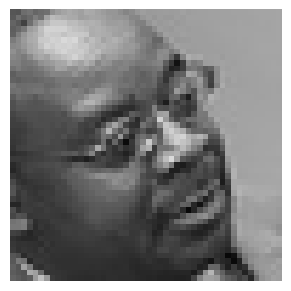

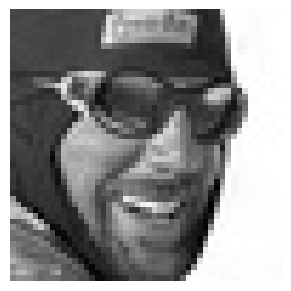

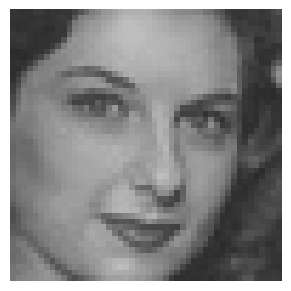

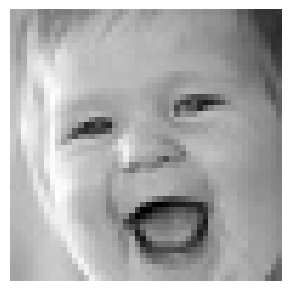

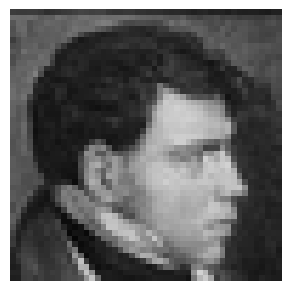

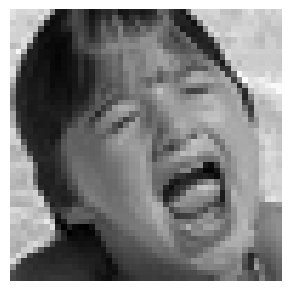

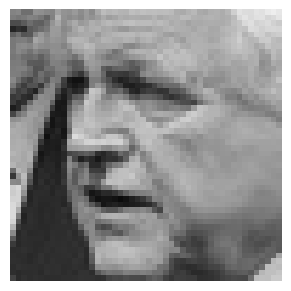

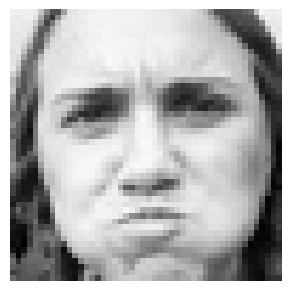

In [2]:
images=glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+1)
    plt.imshow(cv2.imread(image)); plt.axis('off')

In [33]:
image_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/",target_size=(image_size,image_size),color_mode="grayscale",
batch_size=batch_size,class_mode="categorical",shuffle= True)

datagen_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/",target_size=(image_size,image_size),color_mode="grayscale",
batch_size=batch_size,class_mode="categorical",shuffle= True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [34]:
def Convolution(input_tensor, filters, kernel_size):
    x= Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x) 
    x= Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    return x

In [35]:
def Dense_f(input_tensor, nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x) 
    x=Activation("relu")(x)
    x=Dropout(0.25)(x)
    return x

In [36]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution (inputs, 32, (3,3))
    conv_2=Convolution (inputs, 64, (5,5))
    conv_3=Convolution(inputs, 128, (3,3))
    
    flatten=Flatten()(conv_3)

    dense_1=Dense_f(flatten, 256)

    output = Dense (7, activation="softmax") (dense_1)
    model = Model(inputs = [inputs],outputs =[output])

    model.compile(loss =['categorical_crossentropy'],optimizer ='adam', metrics =['accuracy'])
    return model


In [37]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [42]:
epochs=15

steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint("model.weights.h5", monitor='val accuracy', save_weights_only=True,mode ='max', verbose =1)
callbacks =[checkpoint]

In [43]:
history=model.fit( x = train_generator, 
                  steps_per_epoch=steps_per_epoch,
                  epochs=epochs, 
                  validation_data=validation_generator, 
                  validation_steps=validation_steps,
                  callbacks=callbacks)

Epoch 1/15


C:\Users\jenym\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.3305 - loss: 1.8011
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 338s 733ms/step - accuracy: 0.3306 - loss: 1.8008 - val_accuracy: 0.3940 - val_loss: 1.5610
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:23 723ms/step - accuracy: 0.3750 - loss: 1.4586

C:\Users\jenym\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3750 - loss: 1.4586 - val_accuracy: 0.4000 - val_loss: 1.4107
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4863 - loss: 1.3586 
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6593s 15s/step - accuracy: 0.4863 - loss: 1.3586 - val_accuracy: 0.3733 - val_loss: 1.5506
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:33 613ms/step - accuracy: 0.4219 - loss: 1.4523
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4219 - loss: 1.4523 - val_accuracy: 0.4000 - val_loss: 1.4552
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5567 - loss: 1.1826
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.5567 - loss: 1.1827 - val_accuracy: 0.3792 - val_loss: 1.6319
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:02 676ms/step - accuracy: 0.5312 - loss: 1.1378
Epoch 6

In [45]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.4741 - loss: 1.7285


[1.7260180711746216, 0.4717191457748413]

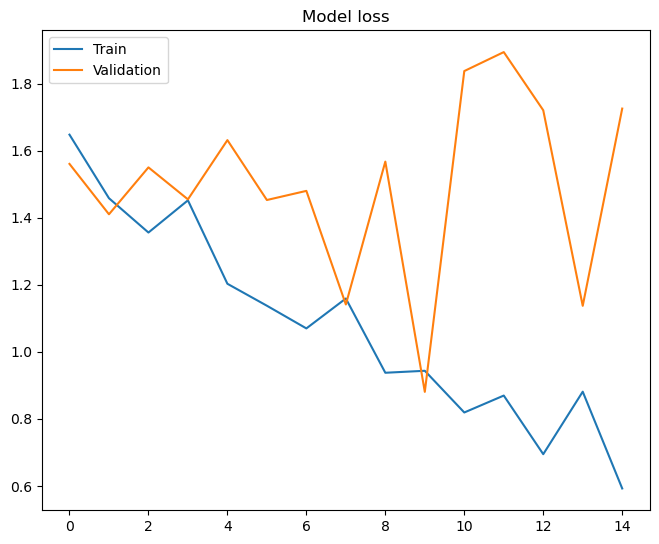

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

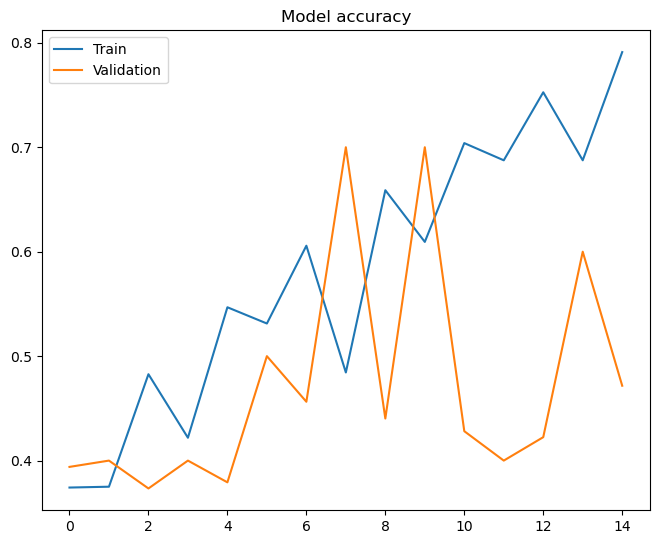

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

**saving model**

In [53]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)